## Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import math
import os 
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

np.random.seed(1234)
tf.random.set_seed(1234)
plt.rcParams["font.family"] = "serif"

2025-08-11 17:45:51.831840: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 17:45:51.878918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-11 17:45:51.878957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-11 17:45:51.880427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-11 17:45:51.888526: I tensorflow/core/platform/cpu_feature_guar

## Data and functions for post processing

In [2]:
vel = 10
path = f'Pre_trained/{vel}ms'
act_disc_model = tf.keras.models.load_model(path)

2025-08-11 17:45:54.372489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46857 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2025-08-11 17:45:54.373242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46858 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2025-08-11 17:45:54.373852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46858 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [3]:
def get_XY_data(model, x_dist):
    diameter = 30.1
    y_dom = np.linspace(-17 * diameter/2, 17 * diameter/2,1000)
    X_test,Y_test,Z_test = np.round(np.meshgrid(x_dist*diameter,y_dom,35),5)
    X_test,Y_test,Z_test = X_test.flatten(),Y_test.flatten(),Z_test.flatten()
    u, v, w, p_y0, k, eps_y0 = model.predict([X_test,Y_test,Z_test])
    
    return u,v,k

In [4]:
def get_ZX_data(model, x_dist, y_dist):
    diameter = 30.1

    y_dom = y_dist*diameter
    z_dom = np.linspace(0.02* diameter/2 ,7.5 * diameter, 1000)
    X_test,Y_test,Z_test = np.round(np.meshgrid(x_dist*diameter,y_dom,z_dom),5)
    X_test,Y_test,Z_test = X_test.flatten(),Y_test.flatten(),Z_test.flatten()
    u, v, w, p, k, eps = model.predict([X_test,Y_test,Z_test])
    return z_dom, u,v,w,k

# Velocity Plots

32/32 [==============================] - 0s 5ms/step


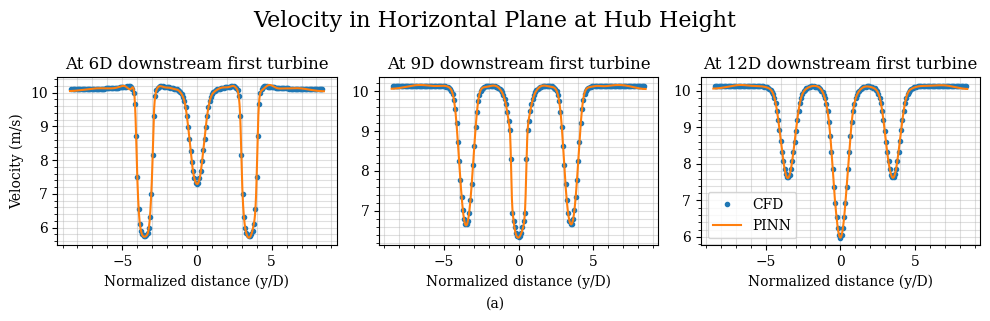

In [5]:
import math
import os 

n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(10, 3))

axs = axs.flatten()


for i in range(n):

    j = 6+i*3
    data = pd.read_csv(f'Plots/Data/{vel}/XY_{j}D.csv')
    axs[i].plot(data['Points_1'][::5]/30.1,data['u'][::5],'.',alpha = 1.0, label= f'CFD')
    axs[i].plot(np.linspace(-17 * 15.05, 17 * 15.05,1000)/30.1,get_XY_data(act_disc_model,j)[0], label= f'PINN')
    axs[i].set_title(f"At {j}D downstream first turbine")

    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()
    if i%3 == 0:
        axs[i].set_ylabel('Velocity (m/s)')

    axs[i].set_xlabel('Normalized distance (y/D)')
    if i==n-1:
        axs[i].legend()

    
fig.suptitle(f'Velocity in Horizontal Plane at Hub Height', fontsize=16)

fig.text(0.5, 0.00, '(a)', ha='center', va='center')

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

outname = f'XY_velocity_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}/'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')



32/32 [==============================] - 0s 4ms/step


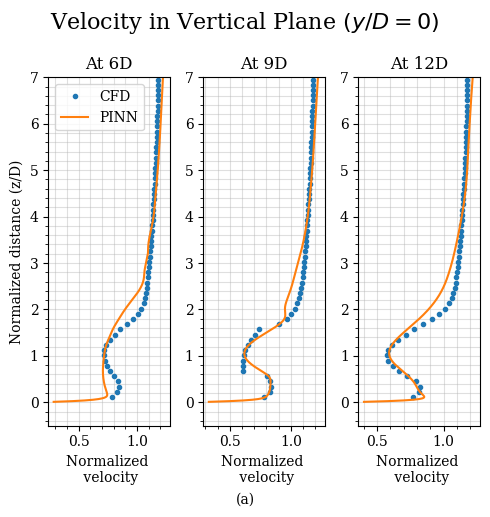

In [9]:
n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(5, 5))

axs = axs.flatten()

for i in range(n):

    j = 6+i*3
    data = pd.read_csv(f'Plots/Data/{vel}/ZX3_{j}D.csv')
    axs[i].plot(data['u'][::15]/vel,data['Points_2'][::15]/30.1,'.',alpha = 1.0, label= f'CFD')

    axs[i].plot(get_ZX_data(act_disc_model,j,0)[1]/vel,get_ZX_data(act_disc_model,j,0)[0]/30.1, label= f'PINN')
    axs[i].set_title(f"At {j}D")
    axs[i].set_ylim(-0.5,7)
    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()
    if i == 0:
        axs[i].set_ylabel('Normalized distance (z/D)')
    axs[i].set_xlabel('Normalized \n velocity')
    if i==0:
        axs[i].legend(loc='upper left')
    
fig.suptitle(r'Velocity in Vertical Plane $(y/D=0)$', fontsize=16)
fig.text(0.5, 0.00, '(a)', ha='center', va='center')

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

outname = f'ZX_mid_velocity_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


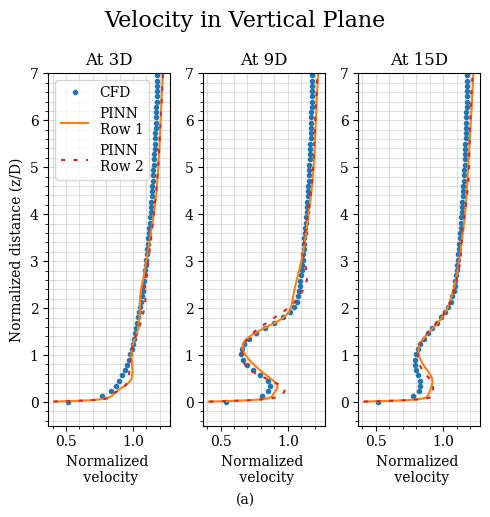

In [10]:
n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(5, 5))

axs = axs.flatten()

for i in range(n):

    j= (2*i+1)*3

    data = pd.read_csv(f'Plots/Data/{vel}/ZX1_{j}D.csv')
    
    axs[i].plot(data['u'][1::15]/vel,data['Points_2'][1::15]/30.1,'.',alpha = 1.0, label= f'CFD')

    axs[i].plot(get_ZX_data(act_disc_model,j,-3.5)[1]/vel,get_ZX_data(act_disc_model,j,-3.5)[0]/30.1, label= f'PINN\nRow 1')
    axs[i].plot(get_ZX_data(act_disc_model,j,3.5)[1]/vel,get_ZX_data(act_disc_model,j,3.5)[0]/30.1,dashes=[2, 4],c='C3', label= f'PINN\nRow 2')
    axs[i].set_title(f"At {j}D")
    axs[i].set_ylim(-0.5,7)
    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()
    if i == 0:
        axs[i].set_ylabel('Normalized distance (z/D)')
    axs[i].set_xlabel('Normalized \n velocity')
    if i==0:
        axs[i].legend()
    
fig.suptitle(f'Velocity in Vertical Plane', fontsize=16)
fig.text(0.5, 0.00, '(a)', ha='center', va='center')

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
outname = f'ZX_side_velocity_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')

# TKE Plots

32/32 [==============================] - 0s 4ms/step


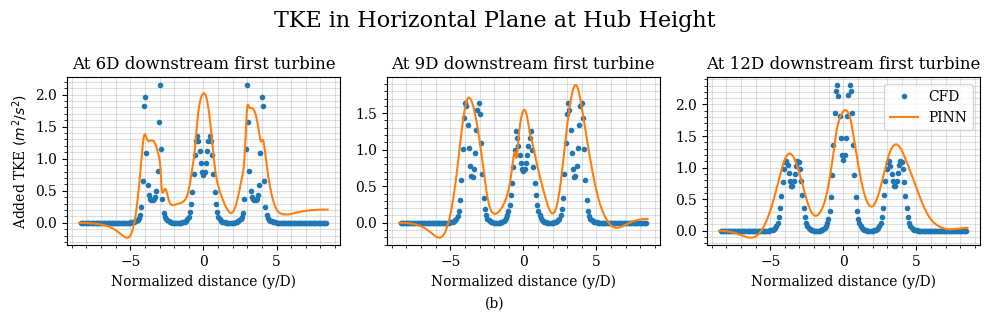

In [11]:
n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(10, 3))

axs = axs.flatten()

for i in range(n):

    j = 6+i*3
    data = pd.read_csv(f'Plots/Data/{vel}/XY_{j}D.csv')

    axs[i].plot(data['Points_1'][::5]/30.1,data['tke'][::5]-data['tke'][1],'.',alpha = 1.0, label= f'CFD')
    axs[i].plot(np.linspace(-17 * 15.05, 17 * 15.05,1000)/30.1,get_XY_data(act_disc_model,j)[2]-get_XY_data(act_disc_model,j)[2][1], label= f'PINN')
    axs[i].set_title(f"At {j}D downstream first turbine")

    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()
    if i%3 == 0:
        axs[i].set_ylabel(r'Added TKE $(m^2/s^2)$')

    
    axs[i].set_xlabel('Normalized distance (y/D)')
    if i==n-1:
        axs[i].legend()
    
fig.suptitle(f'TKE in Horizontal Plane at Hub Height', fontsize=16)
fig.text(0.5, 0.00, '(b)', ha='center', va='center')

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
outname = f'XY_TKE_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')

32/32 [==============================] - 0s 5ms/step


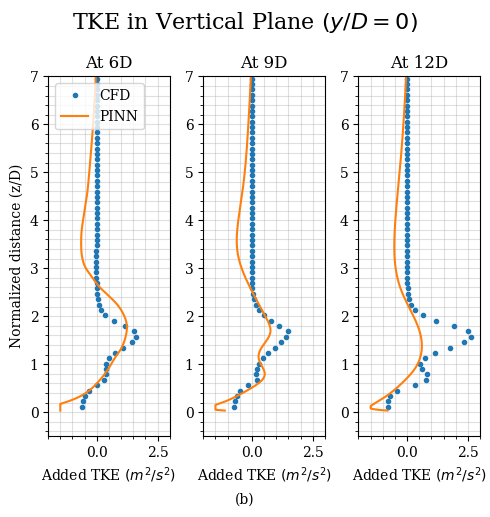

In [12]:
n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(5, 5))

axs = axs.flatten()


for i in range(n):

    j = 6+i*3
    data = pd.read_csv(f'Plots/Data/{vel}/ZX3_{j}D.csv')

    axs[i].plot(data['tke'][::15]-data['tke'][999] ,data['Points_2'][::15]/30.1,'.',alpha = 1.0, label= f'CFD')
    axs[i].plot(get_ZX_data(act_disc_model,j,0)[4][3:]-(get_ZX_data(act_disc_model,j,0)[4][-1]),get_ZX_data(act_disc_model,j,0)[0][3:]/30.1, label= f'PINN')
    
    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()

    axs[i].set_title(f"At {j}D")
    axs[i].set_xlim(-2,3)
    axs[i].set_ylim(-0.5,7)

    if i == 0:
        axs[i].set_ylabel('Normalized distance (z/D)')
        axs[i].legend(loc='upper left')


    axs[i].set_xlabel(r'Added TKE $(m^2/s^2)$')
    
fig.text(0.5, 0.00, '(b)', ha='center', va='center')

fig.suptitle(r'TKE in Vertical Plane $(y/D=0)$', fontsize=16)

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()

outname = f'ZX_mid_TKE_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')

32/32 [==============================] - 0s 5ms/step


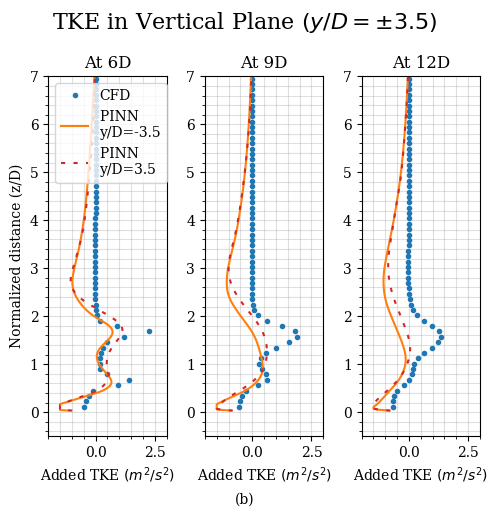

In [13]:
n = 3
cols = 3
rows = math.ceil(n / cols)
fig, axs = plt.subplots(rows, cols, figsize=(5, 5))

axs = axs.flatten()


for i in range(n):

    j = 6+i*3
    data = pd.read_csv(f'Plots/Data/{vel}/ZX1_{j}D.csv')


    axs[i].plot(data['tke'][::15]-data['tke'][999] ,data['Points_2'][::15]/30.1,'.',alpha = 1.0, label= f'CFD')
    axs[i].plot(get_ZX_data(act_disc_model,j,-3.5)[4][3:]-(get_ZX_data(act_disc_model,j,-3.5)[4][-1]),get_ZX_data(act_disc_model,j,-3.5)[0][3:]/30.1, label= f'PINN \ny/D=-3.5')
    axs[i].plot(get_ZX_data(act_disc_model,j,3.5)[4][3:]-(get_ZX_data(act_disc_model,j,3.5)[4][-1]),get_ZX_data(act_disc_model,j,3.5)[0][3:]/30.1,dashes=[2, 4],c='C3', label= f'PINN \ny/D=3.5')

    
    axs[i].grid(which='both',alpha=0.4)
    axs[i].minorticks_on()

    axs[i].set_title(f"At {j}D")
    axs[i].set_xlim(-2,3)
    axs[i].set_ylim(-0.5,7)


    if i == 0:
        axs[i].set_ylabel('Normalized distance (z/D)')
        axs[i].legend(loc='upper left')

    axs[i].set_xlabel(r'Added TKE $(m^2/s^2)$')

    
fig.text(0.5, 0.00, '(b)', ha='center', va='center')

fig.suptitle(r'TKE in Vertical Plane $(y/D=\pm3.5)$', fontsize=16)

# Hide any unused subplots
for j in range(n, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.show()
outname = f'ZX_side_TKE_{vel}.pdf'

subdir = f'Plots/line_plots/{vel}'

os.makedirs(subdir, exist_ok=True)

fullname = os.path.join(subdir, outname) 

plt.savefig(fullname, dpi=300, bbox_inches='tight')

# Contour Plot Data
Contour plots are generated using ParaView with the data saved in 'Sexbierum_contour_data.csv'

In [3]:
Radius = 15.05

for plane in ['XY', 'ZX1', 'ZX2']:
    if plane == 'XY':
        XX,YY,ZZ = np.meshgrid(np.linspace(-10 * Radius, 42 * Radius,500),np.linspace(-17 * Radius, 17 * Radius,500),35)
    elif plane == 'ZX1':
        XX,YY,ZZ = np.meshgrid(np.linspace(-10 * Radius, 42 * Radius,500),7 * Radius,np.linspace(0.02 * Radius, 15 * Radius,500))
    elif plane == 'ZX2':
        XX,YY,ZZ = np.meshgrid(np.linspace(-10 * Radius, 42 * Radius,500),0 * Radius,np.linspace(0.02 * Radius, 15 * Radius,500))
    test_data = [XX.flatten()[:, None], YY.flatten()[:, None], ZZ.flatten()[:, None]]
    u,v,w,p,k,eps = act_disc_model.predict(test_data)

    ti = np.sqrt(k/1.5)/(np.sqrt(u**2+v**2+w**2))

    dict = {'x': XX.flatten().tolist(), 'y': YY.flatten().tolist(), 'z': ZZ.flatten().tolist(),
                    'u': u.flatten()[:,].tolist(), 'v': v.flatten()[:,].tolist(), 'w': w.flatten()[:,].tolist(),
                    'p': p.flatten()[:,].tolist(), 'k': k.flatten()[:,].tolist(), 'eps': eps.flatten()[:,].tolist(),
                    'ti': ti.flatten()[:,].tolist()}

    df = pd.DataFrame(dict)


    outname = f'multi_contour_data_{plane}.csv'

    subdir = f'Plots/csv_data/{vel}'

    os.makedirs(subdir, exist_ok=True)

    fullname = os.path.join(subdir, outname) 

    df.to_csv(fullname)

7813/7813 [==============================] - 37s 5ms/step
